In [ ]:
#default_exp mabe

# Meeting Mice

> Drawing some graphics for the AIcrowd [Multi-Agent BEhaviour Challenge](https://www.aicrowd.com/challenges/multi-agent-behavior-representation-modeling-measurement-and-applications)

The challenge asks you to classify motion of mice when presented with another mouse. We are given a set of keypoints for each mouse for each frame (as well as an associated label for the type of behaviour). I want to draw these mice with 'trails' to show the motion path and capture many frames worth of data in one image.

This didn't turn out particularly useful in the actual competition but it was a fun diversion :)

In [ ]:
#hide
from days_of_code.core import *
import numpy as np
import cairocffi as cairo
from PIL import Image

I am working with a small sample of the data saved with numpy.

In [ ]:
sequence = np.load('data/MABe/example_sequence.npy')

FOr each frame (30fps video) the positions of keypoints on the mouse (nose, ears, neck, sides and tail) have been annotated. There is also a label for the behaviour happening at each time instant.

In [ ]:
sequence[0] # Two mice, list of X and list of Y for each for one frame

array([[[298.99367828, 266.99367828, 248.99367828, 243.99367828,
         181.99367828, 144.99367828, 125.99367828],
        [140.75094149, 194.75094149, 138.75094149, 169.75094149,
         240.75094149, 167.75094149, 241.75094149]],

       [[191.68942719, 226.68942719, 167.68942719, 200.68942719,
         235.68942719, 161.68942719, 203.68942719],
        [283.87298664, 323.87298664, 329.87298664, 342.87298664,
         429.87298664, 433.87298664, 487.87298664]]])

In [ ]:
imw, imh = 1024, 570 # The image dimensions in which the mice move about

With some basic cairo drawing we can repeatedly draw the mice and animate them to watch the motion:

In [ ]:
def drawmouse(ctx, keypoints, w, h):
    x, y = keypoints[0]*w/imw, keypoints[1]*h/imh
    
    # Head 
    ctx.move_to(x[3], y[3])
    ctx.line_to(x[1], y[1])
    ctx.line_to(x[0], y[0])
    ctx.line_to(x[2], y[2])
    ctx.line_to(x[3], y[3])
    ctx.close_path()
    ctx.set_source_rgb(1, 0.5, 0)
    ctx.fill_preserve()
    ctx.set_source_rgb(1, 1, 0)
    ctx.set_line_width(3)
    ctx.stroke()
    
    # Body 
    ctx.line_to(x[4], y[4])
    ctx.line_to(x[6], y[6])
    ctx.line_to(x[6], y[5])
    ctx.line_to(x[3], y[3])
    ctx.close_path()
    ctx.set_source_rgb(1, 0.5, 0)
    ctx.fill_preserve()
    ctx.set_source_rgb(1, 1, 0)
    ctx.set_line_width(3)
    ctx.stroke()

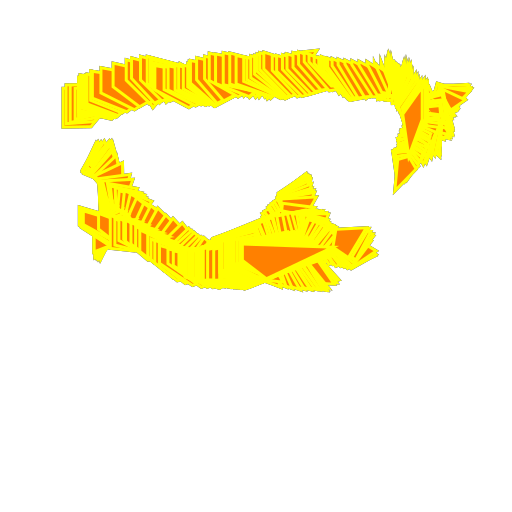

In [ ]:
#skiptest
import ipywidgets as widgets

# Set up surface
surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, 512, 512) # Create the surface
ctx = cairo.Context(surface)

widget = widgets.Image(
    value=surface.write_to_png(),
    format='png',
    width=512,
    height=512,
)
display(widget)

for ks in sequence[:200]:
    drawmouse(ctx, ks[0], 512, 300)
    drawmouse(ctx, ks[1], 512, 300)
    widget.value = surface.write_to_png()
    
display_surface(surface)

We want a static frame, so we modify the above with some colour to show both mice and 'trails' of where they have been and are going.

In [ ]:
#export
def draw_instant(ctx, seq, w, h, T, n=30, step=3):
    
    for i in range(T-n, T+n, step):
        for mouse in [0, 1]:
            if i >= 0:
                keypoints = seq[i][mouse]
                x, y = keypoints[0]*w/imw, keypoints[1]*h/imh

                # Head 
                ctx.move_to(x[3], y[3])
                ctx.line_to(x[1], y[1])
                ctx.line_to(x[0], y[0])
                ctx.line_to(x[2], y[2])
                ctx.line_to(x[3], y[3])
                ctx.close_path()

                ctx.set_source_rgba(0.5+0.5*(T-i)/n, 0.5-0.5*abs(T-i)/n, 0.2+mouse*0.6, 1-abs(T-i)/n)
                ctx.fill_preserve()
                ctx.stroke()

                # Body 
                ctx.line_to(x[4], y[4])
                ctx.line_to(x[6], y[6])
                ctx.line_to(x[6], y[5])
                ctx.line_to(x[3], y[3])
                ctx.close_path()
                ctx.set_source_rgba(0.2+mouse*0.6, 0.5+0.5*(T-i)/n, 0.5-0.5*abs(T-i)/n, 1-abs(T-i)/n)
                ctx.fill_preserve()
                ctx.stroke()
    for mouse in [0, 1]:
        keypoints = seq[T][mouse]
        x, y = keypoints[0]*w/imw, keypoints[1]*h/imh
        ctx.move_to(x[3], y[3])
        ctx.line_to(x[1], y[1])
        ctx.line_to(x[0], y[0])
        ctx.line_to(x[2], y[2])
        ctx.line_to(x[3], y[3])
        ctx.close_path()
        ctx.set_source_rgba(1, 0.5, 0.1, 1)
        if mouse == 1:
            ctx.set_source_rgba(1, 0.5, 0.8, 1)

        ctx.fill_preserve()
        ctx.set_source_rgb(0, 0, 0)
        ctx.set_line_width(3)
        ctx.stroke()

        # Body 
        ctx.line_to(x[4], y[4])
        ctx.line_to(x[6], y[6])
        ctx.line_to(x[6], y[5])
        ctx.line_to(x[3], y[3])
        ctx.close_path()
        ctx.set_source_rgba(0.5, 1, 0.1, 1)
        if mouse == 1:
            ctx.set_source_rgba(0.5, 1, 0.8, 1)
        ctx.fill_preserve()
        ctx.set_source_rgb(0, 0, 0)
        ctx.set_line_width(3)
        ctx.stroke()

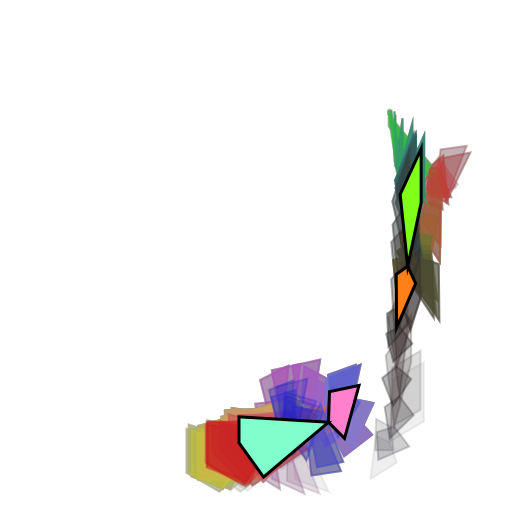

In [ ]:
# Set up surface
surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, 512, 512) # Create the surface
ctx = cairo.Context(surface)
draw_instant(ctx, sequence, 512, 512, 200, n=80, step=5)
surface.write_to_png('test.png') # Saving
display_surface(surface)

This needs to be quite fast - let's see how long it takes to make 100 images:

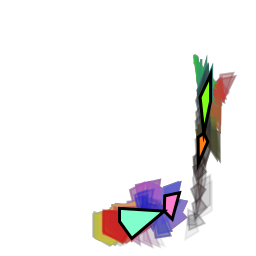

CPU times: user 667 ms, sys: 7.89 ms, total: 675 ms
Wall time: 673 ms


In [ ]:
%%time
for _ in range(100):
    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, 256, 256) # Create the surface
    ctx = cairo.Context(surface)
    draw_instant(ctx, sequence, 256, 256, 200, n=80, step=5)
display_surface(surface)

I fed a few thousand of these images to a resnet and trained it for a bit, but couldn't get more than ~66% accuracy so I gave up. The competition took the bulk of my coding time today so this is a short notebook. See you tomorrow.